# 안녕하세요^^ 
# AIVLE 미니 프로젝트에 오신 여러분을 환영합니다.
* 본 과정에서는 실제 사례와 데이터를 기반으로 문제를 해결하는 전체 과정을 자기 주도형 실습으로 진행해볼 예정입니다.
* 앞선 교육과정을 정리하는 마음과 지금까지 배운 내용을 바탕으로 문제 해결을 해볼게요!
* 미니 프로젝트를 통한 문제 해결 과정 'A에서 Z까지', 지금부터 시작합니다!

---

## 0. 환경 설정하기

### 1) 구글 드라이브 연결하기

In [1]:
# 코랩 사용 시 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2) 경로 확인하기
- "WORK_SPACE" 에 본인 작업 경로 작성 후 실행(구글 드라이브 최상위에 압축해제 시 그대로 실행. 수정 X).<br>

<font color="red">※ 주의. 나머지 경로는 절대 변경하지 마세요.</font>

In [2]:
# ROOT_PATH 확인 
import os

# 구글 드라이브 내 프로젝트 압축해제된 영역 (구글 드라이브 최상위에 압축해제 시 그대로 실행 수정 X)
WORK_SPACE = "kt aivle/mini3"

if os.getcwd() == '/content' :
  # 구글 드라이브 사용 시 
  ROOT_PATH = "/content/drive/MyDrive/"+WORK_SPACE+"/AIVLE3rd_individual"
else :
  ROOT_PATH = os.path.abspath('..')
# Train 데이터 셋 경로
TRAIN_PATH = ROOT_PATH + "/train"
# MODEL 저장 경로
MODEL_PATH = ROOT_PATH + "/model"

### 3) 라이브러리 불러오기
필요시 추가 라이브러리는 설치해서 사용하세요.

In [3]:
# 필요 라이브러리 불러오기.
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Embedding
from keras.layers import Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.backend import clear_session

### 4) GPU 환경 확인하기
tensorflow가 GPU를 활용하고 있는지 확인하려면, tensorflow에서 제공하는 device_lib 라이브러리를 활용하면 됩니다.

In [ ]:
# GPU 환경 확인하기
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7103369379471590121
 xla_global_id: -1]

---

# 1. ImageDataGenerator 생성하기
앞의 <font color="red">__'[study] 2.데이터전처리'__ </font>과정에서 사용하였던 ImageDataGenerator를 그대로 가져오시면 됩니다.

<font color="green">[실습문제]</font> 1. ImageDataGenerator 생성하기
+ 모델 검증을 위해 데이터를 train:validation(8:2)로 분할합니다.
+ 모델 성능 개선을 위해 데이터 증식(Data augmentation)이 필요 시 자유롭게 설정

In [6]:
# 실습해보세요.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #validation_split=0.2,
    rotation_range=90,  # 무작위 각도 범위
    width_shift_range=0.2,   # 수평 이동 범위 비율
    height_shift_range=0.2,  # 수직 이동 범위 비율
    shear_range=0.3,     # 층 밀리기 강도
    zoom_range=0.3,     # 무작위 줌 범위 
    horizontal_flip=True,  # 가로로 뒤집음
    # vertical_flip = True,    # 세로로 뒤집음 필요없을 듯 사람을 하다보니
    fill_mode='nearest',    # 변환된 이미지에서 생기는 빈 부분 채우는 방법
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

batch_size=16
img_height = 480
img_width=854

# train_genrator 생성
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    batch_size=16,
    target_size=(img_height, img_width),
    class_mode='categorical',
    subset='training',
    shuffle = True
)

# validation_generator 생성
validation_generator = val_datagen.flow_from_directory(
    TRAIN_PATH,
    batch_size=16,
    target_size=(img_height, img_width),
    subset='validation',
    class_mode='categorical',
    shuffle = False
)

Found 867 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


In [ ]:
print(train_generator.image_shape)
print(validation_generator.image_shape)

(480, 854, 3)
(480, 854, 3)


---

# 2. 모델 구성하기
+ KeyPoint : 합성곱 신경망 (CNN) 모델 구성.

<font color="green">[실습문제]</font> 2. CNN 모델을 설계해 보세요.
* 케라스를 이용해서 CNN 모델을 설계합니다.

In [7]:
clear_session()
model=Sequential()

model.add(Input(shape=(480,854,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))
model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 480, 854, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 480, 854, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 480, 854, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 480, 854, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 240, 427, 32)     0         
 )                                                               
                                                        

<font color="green">[실습문제]</font> 3. 모델을 학습시켜 보세요.
* 위에서 설계한 모델에 데이터를 가지고 학습을 진행 합니다. 
* history 변수에 학습 결과를 입력 받습니다.
* callback 함수로 ModelCheckpoint와 EarlyStopping을 사용하세요.(best만 저장)
* 학습한 모델의 weight를 경로 MODEL_PATH 에 저장해주세요.
* val_loss 기준으로 모니터링 해주세요.

In [8]:
# early_stopping 
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/kt aivle/mini3/AIVLE3rd_individual/model/model.ckpt',
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True,
                      save_weights_only=False
)
  

# early_stopping
early_stopping = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True
)

In [9]:
# 모델 학습
history = model.fit(train_generator, validation_data=validation_generator
          ,epochs=130, verbose=1, callbacks=[early_stopping, checkpoint])


Epoch 1/500
55/55 [==============================] - ETA: 0s - loss: 1.5776 - accuracy: 0.4602

55/55 [==============================] - 326s 6s/step - loss: 1.5776 - accuracy: 0.4602
Epoch 2/500
55/55 [==============================] - ETA: 0s - loss: 1.1283 - accuracy: 0.5225

55/55 [==============================] - 80s 1s/step - loss: 1.1283 - accuracy: 0.5225
Epoch 3/500
55/55 [==============================] - ETA: 0s - loss: 1.0086 - accuracy: 0.5525

55/55 [==============================] - 80s 1s/step - loss: 1.0086 - accuracy: 0.5525
Epoch 4/500
55/55 [==============================] - ETA: 0s - loss: 1.0171 - accuracy: 0.5536

55/55 [==============================] - 80s 1s/step - loss: 1.0171 - accuracy: 0.5536
Epoch 5/500
55/55 [==============================] - ETA: 0s - loss: 0.9390 - accuracy: 0.5675

55/55 [==============================] - 80s 1s/step - loss: 0.9390 - accuracy: 0.5675
Epoch 6/500
55/55 [==============================] - ETA: 0s - loss: 0.9498 - accuracy: 0.5698

55/55 [==============================] - 80s 1s/step - loss: 0.9498 - accuracy: 0.5698
Epoch 7/500
55/55 [==============================] - ETA: 0s - loss: 0.8853 - accuracy: 0.6148

55/55 [==============================] - 80s 1s/step - loss: 0.8853 - accuracy: 0.6148
Epoch 8/500
55/55 [==============================] - ETA: 0s - loss: 0.8729 - accuracy: 0.6078

55/55 [==============================] - 80s 1s/step - loss: 0.8729 - accuracy: 0.6078
Epoch 9/500
55/55 [==============================] - ETA: 0s - loss: 0.8707 - accuracy: 0.6032

55/55 [==============================] - 80s 1s/step - loss: 0.8707 - accuracy: 0.6032
Epoch 10/500
55/55 [==============================] - ETA: 0s - loss: 0.8258 - accuracy: 0.6286

55/55 [==============================] - 80s 1s/step - loss: 0.8258 - accuracy: 0.6286
Epoch 11/500
55/55 [==============================] - ETA: 0s - loss: 0.8303 - accuracy: 0.6113

55/55 [==============================] - 79s 1s/step - loss: 0.8303 - accuracy: 0.6113
Epoch 12/500
55/55 [==============================] - ETA: 0s - loss: 0.8653 - accuracy: 0.6067

55/55 [==============================] - 79s 1s/step - loss: 0.8653 - accuracy: 0.6067
Epoch 13/500
55/55 [==============================] - ETA: 0s - loss: 0.8234 - accuracy: 0.6321

55/55 [==============================] - 80s 1s/step - loss: 0.8234 - accuracy: 0.6321
Epoch 14/500
55/55 [==============================] - ETA: 0s - loss: 0.9897 - accuracy: 0.5490

55/55 [==============================] - 80s 1s/step - loss: 0.9897 - accuracy: 0.5490
Epoch 15/500
55/55 [==============================] - ETA: 0s - loss: 0.8835 - accuracy: 0.5986

55/55 [==============================] - 80s 1s/step - loss: 0.8835 - accuracy: 0.5986
Epoch 16/500
55/55 [==============================] - ETA: 0s - loss: 0.8485 - accuracy: 0.6182

55/55 [==============================] - 82s 1s/step - loss: 0.8485 - accuracy: 0.6182
Epoch 17/500
55/55 [==============================] - ETA: 0s - loss: 0.8286 - accuracy: 0.6205

55/55 [==============================] - 82s 1s/step - loss: 0.8286 - accuracy: 0.6205
Epoch 18/500
55/55 [==============================] - ETA: 0s - loss: 0.7905 - accuracy: 0.6413

55/55 [==============================] - 82s 1s/step - loss: 0.7905 - accuracy: 0.6413
Epoch 19/500
55/55 [==============================] - ETA: 0s - loss: 0.8290 - accuracy: 0.6286

55/55 [==============================] - 81s 1s/step - loss: 0.8290 - accuracy: 0.6286
Epoch 20/500
55/55 [==============================] - ETA: 0s - loss: 0.7494 - accuracy: 0.6448

55/55 [==============================] - 80s 1s/step - loss: 0.7494 - accuracy: 0.6448
Epoch 21/500
55/55 [==============================] - ETA: 0s - loss: 0.7712 - accuracy: 0.6632

55/55 [==============================] - 80s 1s/step - loss: 0.7712 - accuracy: 0.6632
Epoch 22/500
55/55 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.6286

55/55 [==============================] - 85s 2s/step - loss: 0.7401 - accuracy: 0.6286
Epoch 23/500
55/55 [==============================] - ETA: 0s - loss: 0.7245 - accuracy: 0.6690

55/55 [==============================] - 85s 2s/step - loss: 0.7245 - accuracy: 0.6690
Epoch 24/500
55/55 [==============================] - ETA: 0s - loss: 0.7611 - accuracy: 0.6667

55/55 [==============================] - 84s 2s/step - loss: 0.7611 - accuracy: 0.6667
Epoch 25/500
55/55 [==============================] - ETA: 0s - loss: 0.7230 - accuracy: 0.6482

55/55 [==============================] - 82s 1s/step - loss: 0.7230 - accuracy: 0.6482
Epoch 26/500
55/55 [==============================] - ETA: 0s - loss: 0.7224 - accuracy: 0.6701

55/55 [==============================] - 79s 1s/step - loss: 0.7224 - accuracy: 0.6701
Epoch 27/500
55/55 [==============================] - ETA: 0s - loss: 0.7085 - accuracy: 0.6747

55/55 [==============================] - 80s 1s/step - loss: 0.7085 - accuracy: 0.6747
Epoch 28/500
55/55 [==============================] - ETA: 0s - loss: 0.7522 - accuracy: 0.6621

55/55 [==============================] - 80s 1s/step - loss: 0.7522 - accuracy: 0.6621
Epoch 29/500
55/55 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.6874

55/55 [==============================] - 84s 2s/step - loss: 0.6917 - accuracy: 0.6874
Epoch 30/500
55/55 [==============================] - ETA: 0s - loss: 0.7036 - accuracy: 0.6517

55/55 [==============================] - 82s 1s/step - loss: 0.7036 - accuracy: 0.6517
Epoch 31/500
55/55 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.6621

55/55 [==============================] - 80s 1s/step - loss: 0.6843 - accuracy: 0.6621
Epoch 32/500
55/55 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.6794

55/55 [==============================] - 79s 1s/step - loss: 0.6886 - accuracy: 0.6794
Epoch 33/500
55/55 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.7036

55/55 [==============================] - 80s 1s/step - loss: 0.6307 - accuracy: 0.7036
Epoch 34/500
55/55 [==============================] - ETA: 0s - loss: 0.6475 - accuracy: 0.6851

55/55 [==============================] - 79s 1s/step - loss: 0.6475 - accuracy: 0.6851
Epoch 35/500
55/55 [==============================] - ETA: 0s - loss: 0.6571 - accuracy: 0.6828

55/55 [==============================] - 79s 1s/step - loss: 0.6571 - accuracy: 0.6828
Epoch 36/500
55/55 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.6736

55/55 [==============================] - 79s 1s/step - loss: 0.6964 - accuracy: 0.6736
Epoch 37/500
55/55 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.6794

55/55 [==============================] - 80s 1s/step - loss: 0.6680 - accuracy: 0.6794
Epoch 38/500
55/55 [==============================] - ETA: 0s - loss: 0.6297 - accuracy: 0.6782

55/55 [==============================] - 79s 1s/step - loss: 0.6297 - accuracy: 0.6782
Epoch 39/500
55/55 [==============================] - ETA: 0s - loss: 0.6006 - accuracy: 0.7163

55/55 [==============================] - 79s 1s/step - loss: 0.6006 - accuracy: 0.7163
Epoch 40/500
55/55 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.6747

55/55 [==============================] - 80s 1s/step - loss: 0.6867 - accuracy: 0.6747
Epoch 41/500
55/55 [==============================] - ETA: 0s - loss: 0.6561 - accuracy: 0.6747

55/55 [==============================] - 80s 1s/step - loss: 0.6561 - accuracy: 0.6747
Epoch 42/500
55/55 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.6690

55/55 [==============================] - 79s 1s/step - loss: 0.6594 - accuracy: 0.6690
Epoch 43/500
55/55 [==============================] - ETA: 0s - loss: 0.6538 - accuracy: 0.6990

55/55 [==============================] - 79s 1s/step - loss: 0.6538 - accuracy: 0.6990
Epoch 44/500
55/55 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.6828

55/55 [==============================] - 79s 1s/step - loss: 0.6451 - accuracy: 0.6828
Epoch 45/500
55/55 [==============================] - ETA: 0s - loss: 0.6321 - accuracy: 0.6943

55/55 [==============================] - 79s 1s/step - loss: 0.6321 - accuracy: 0.6943
Epoch 46/500
55/55 [==============================] - ETA: 0s - loss: 0.6369 - accuracy: 0.6840

55/55 [==============================] - 79s 1s/step - loss: 0.6369 - accuracy: 0.6840
Epoch 47/500
55/55 [==============================] - ETA: 0s - loss: 0.6263 - accuracy: 0.7070

55/55 [==============================] - 79s 1s/step - loss: 0.6263 - accuracy: 0.7070
Epoch 48/500
55/55 [==============================] - ETA: 0s - loss: 0.6287 - accuracy: 0.6886

55/55 [==============================] - 80s 1s/step - loss: 0.6287 - accuracy: 0.6886
Epoch 49/500
55/55 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.6909

55/55 [==============================] - 79s 1s/step - loss: 0.6128 - accuracy: 0.6909
Epoch 50/500
55/55 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.6828

55/55 [==============================] - 80s 1s/step - loss: 0.6542 - accuracy: 0.6828
Epoch 51/500
55/55 [==============================] - ETA: 0s - loss: 0.6627 - accuracy: 0.6805

55/55 [==============================] - 80s 1s/step - loss: 0.6627 - accuracy: 0.6805
Epoch 52/500
55/55 [==============================] - ETA: 0s - loss: 0.6222 - accuracy: 0.6828

55/55 [==============================] - 79s 1s/step - loss: 0.6222 - accuracy: 0.6828
Epoch 53/500
55/55 [==============================] - ETA: 0s - loss: 0.6238 - accuracy: 0.6817

55/55 [==============================] - 79s 1s/step - loss: 0.6238 - accuracy: 0.6817
Epoch 54/500
55/55 [==============================] - ETA: 0s - loss: 0.6165 - accuracy: 0.7059

55/55 [==============================] - 79s 1s/step - loss: 0.6165 - accuracy: 0.7059
Epoch 55/500
55/55 [==============================] - ETA: 0s - loss: 0.6126 - accuracy: 0.6817

55/55 [==============================] - 79s 1s/step - loss: 0.6126 - accuracy: 0.6817
Epoch 56/500
55/55 [==============================] - ETA: 0s - loss: 0.6456 - accuracy: 0.6897

55/55 [==============================] - 80s 1s/step - loss: 0.6456 - accuracy: 0.6897
Epoch 57/500
55/55 [==============================] - ETA: 0s - loss: 0.6041 - accuracy: 0.7128

55/55 [==============================] - 80s 1s/step - loss: 0.6041 - accuracy: 0.7128
Epoch 58/500
55/55 [==============================] - ETA: 0s - loss: 0.6379 - accuracy: 0.7082

55/55 [==============================] - 79s 1s/step - loss: 0.6379 - accuracy: 0.7082
Epoch 59/500
55/55 [==============================] - ETA: 0s - loss: 0.6148 - accuracy: 0.6920

55/55 [==============================] - 79s 1s/step - loss: 0.6148 - accuracy: 0.6920
Epoch 60/500
55/55 [==============================] - ETA: 0s - loss: 0.5745 - accuracy: 0.7001

55/55 [==============================] - 80s 1s/step - loss: 0.5745 - accuracy: 0.7001
Epoch 61/500
55/55 [==============================] - ETA: 0s - loss: 0.6163 - accuracy: 0.6909

55/55 [==============================] - 80s 1s/step - loss: 0.6163 - accuracy: 0.6909
Epoch 62/500
55/55 [==============================] - ETA: 0s - loss: 0.6260 - accuracy: 0.7093

55/55 [==============================] - 80s 1s/step - loss: 0.6260 - accuracy: 0.7093
Epoch 63/500
55/55 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.6863

55/55 [==============================] - 79s 1s/step - loss: 0.6306 - accuracy: 0.6863
Epoch 64/500
55/55 [==============================] - ETA: 0s - loss: 0.5982 - accuracy: 0.7116

55/55 [==============================] - 80s 1s/step - loss: 0.5982 - accuracy: 0.7116
Epoch 65/500
55/55 [==============================] - ETA: 0s - loss: 0.5832 - accuracy: 0.7059

55/55 [==============================] - 80s 1s/step - loss: 0.5832 - accuracy: 0.7059
Epoch 66/500
55/55 [==============================] - ETA: 0s - loss: 0.5822 - accuracy: 0.7209

55/55 [==============================] - 80s 1s/step - loss: 0.5822 - accuracy: 0.7209
Epoch 67/500
55/55 [==============================] - ETA: 0s - loss: 0.6029 - accuracy: 0.7059

55/55 [==============================] - 80s 1s/step - loss: 0.6029 - accuracy: 0.7059
Epoch 68/500
55/55 [==============================] - ETA: 0s - loss: 0.6355 - accuracy: 0.6817

55/55 [==============================] - 80s 1s/step - loss: 0.6355 - accuracy: 0.6817
Epoch 69/500
55/55 [==============================] - ETA: 0s - loss: 0.6455 - accuracy: 0.6667

55/55 [==============================] - 80s 1s/step - loss: 0.6455 - accuracy: 0.6667
Epoch 70/500
55/55 [==============================] - ETA: 0s - loss: 0.5838 - accuracy: 0.6943

55/55 [==============================] - 80s 1s/step - loss: 0.5838 - accuracy: 0.6943
Epoch 71/500
55/55 [==============================] - ETA: 0s - loss: 0.5539 - accuracy: 0.7405

55/55 [==============================] - 80s 1s/step - loss: 0.5539 - accuracy: 0.7405
Epoch 72/500
55/55 [==============================] - ETA: 0s - loss: 0.5698 - accuracy: 0.7093

55/55 [==============================] - 80s 1s/step - loss: 0.5698 - accuracy: 0.7093
Epoch 73/500
55/55 [==============================] - ETA: 0s - loss: 0.5850 - accuracy: 0.7001

55/55 [==============================] - 80s 1s/step - loss: 0.5850 - accuracy: 0.7001
Epoch 74/500
55/55 [==============================] - ETA: 0s - loss: 0.5694 - accuracy: 0.7140

55/55 [==============================] - 80s 1s/step - loss: 0.5694 - accuracy: 0.7140
Epoch 75/500
55/55 [==============================] - ETA: 0s - loss: 0.5634 - accuracy: 0.6920

55/55 [==============================] - 80s 1s/step - loss: 0.5634 - accuracy: 0.6920
Epoch 76/500
55/55 [==============================] - ETA: 0s - loss: 0.5731 - accuracy: 0.7220

55/55 [==============================] - 80s 1s/step - loss: 0.5731 - accuracy: 0.7220
Epoch 77/500
55/55 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.7001

55/55 [==============================] - 80s 1s/step - loss: 0.5991 - accuracy: 0.7001
Epoch 78/500
55/55 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.7209

55/55 [==============================] - 79s 1s/step - loss: 0.5553 - accuracy: 0.7209
Epoch 79/500
55/55 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.7070

55/55 [==============================] - 79s 1s/step - loss: 0.5474 - accuracy: 0.7070
Epoch 80/500
55/55 [==============================] - ETA: 0s - loss: 0.5454 - accuracy: 0.7105

55/55 [==============================] - 79s 1s/step - loss: 0.5454 - accuracy: 0.7105
Epoch 81/500
55/55 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.7105

55/55 [==============================] - 80s 1s/step - loss: 0.5621 - accuracy: 0.7105
Epoch 82/500
55/55 [==============================] - ETA: 0s - loss: 0.6235 - accuracy: 0.7047

55/55 [==============================] - 79s 1s/step - loss: 0.6235 - accuracy: 0.7047
Epoch 83/500
55/55 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.7140

55/55 [==============================] - 79s 1s/step - loss: 0.5664 - accuracy: 0.7140
Epoch 84/500
55/55 [==============================] - ETA: 0s - loss: 0.5833 - accuracy: 0.6990

55/55 [==============================] - 79s 1s/step - loss: 0.5833 - accuracy: 0.6990
Epoch 85/500
55/55 [==============================] - ETA: 0s - loss: 0.5594 - accuracy: 0.7266

55/55 [==============================] - 80s 1s/step - loss: 0.5594 - accuracy: 0.7266
Epoch 86/500
55/55 [==============================] - ETA: 0s - loss: 0.5460 - accuracy: 0.7174

55/55 [==============================] - 80s 1s/step - loss: 0.5460 - accuracy: 0.7174
Epoch 87/500
55/55 [==============================] - ETA: 0s - loss: 0.5803 - accuracy: 0.6886

55/55 [==============================] - 79s 1s/step - loss: 0.5803 - accuracy: 0.6886
Epoch 88/500
55/55 [==============================] - ETA: 0s - loss: 0.5534 - accuracy: 0.7197

55/55 [==============================] - 80s 1s/step - loss: 0.5534 - accuracy: 0.7197
Epoch 89/500
55/55 [==============================] - ETA: 0s - loss: 0.5466 - accuracy: 0.7209

55/55 [==============================] - 80s 1s/step - loss: 0.5466 - accuracy: 0.7209
Epoch 90/500
55/55 [==============================] - ETA: 0s - loss: 0.5511 - accuracy: 0.7059

55/55 [==============================] - 80s 1s/step - loss: 0.5511 - accuracy: 0.7059
Epoch 91/500
20/55 [=========>....................] - ETA: 51s - loss: 0.5802 - accuracy: 0.6844

KeyboardInterrupt: ignored

<font color="green">[실습문제]</font> 4. 모델 저장하기 
* 만들어진 모델를 기반으로 모델파일로 저장해주세요.
* 파일 저장 전에 ModelCheckpoint의 가중치(weights)를 로딩해주세요.
* 저장위치는 MODEL_PATH 입니다.
* 파일명은 <font color="red">[개인] 미니프로젝트3차_A000000_OOO.h5</font>

><font color="red">[Hint]</font><br>
>모델 가중치는 load_weight 매소드로 불러옵니다.<br>
>모델 저장시에는 model.save 매소드를 사용합니다. 

In [ ]:
from google.colab import files
files.download('[개인]미니프로젝트3차_A023123_이시영.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 실습해보세요.
from keras.models import load_model

model.save('[개인]미니프로젝트3차_A023123_이시영.h5')




In [ ]:
from keras.models import load_model
model = load_model('[개인]미니프로젝트3차_A023123_이시영.h5')

---

# 3. 모델 평가하기

<font color="green">[실습문제]</font> 5. 훈련 과정에서 epoch에 따른 정확도와 손실을 시각화화여 확인합니다.

In [ ]:
# 실습해보세요.
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history['accuracy'][-1])
print(history.history['val_accuracy'][-1])
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])




0.7510791420936584
0.7790697813034058
0.3304952383041382
0.7221317887306213


<font color="green">[실습문제]</font> 6. validation 데이터를 기준으로 학습한 모델을 적용해서 f1 Score를 계산하세요.

* <font color="red">hint.</font> sklearn.metrics 패키지에서 f1_score를 사용하세요.

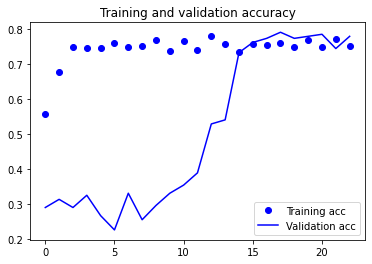

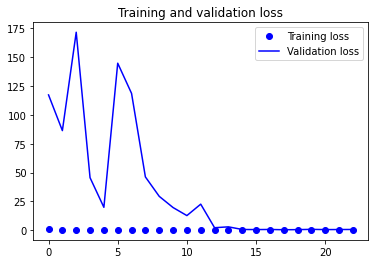

In [ ]:
# 실습해보세요.
from sklearn.metrics import f1_score
import tensorflow as tf
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

---

## [추가학습] 모델 비교하기 
_시간이 남으면 해보세요._

<font color="green">[실습문제]</font> 7. 모델 구조를 변경해 보거나 다른 모델들을 만들어 보고 성능을 비교해 최고의 모델을 만들어 보세요.
- 여러분들이 배운 모델들을 다양하게 만들어 보고 성능을 비교해 보세요.
- ImageDataGenerator를 변경하면 성능 개선도 가능합니다. 

In [ ]:
# 실습해보세요.





